In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
from plotly import tools
import plotly.figure_factory as ff
import warnings
warnings.filterwarnings('ignore')
import matplotlib.dates as mdates
import matplotlib.ticker as ticker #used for changing tick spacing
from finta import TA
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import time
import plotly.express as px
import sys
import os
from torch.utils.data import DataLoader, TensorDataset
import optuna

In [3]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\src")

In [4]:
from data_prep import train_test_split
from data_prep import add_technical_indicators
from data_prep import on_balance_volume_creation
from train import train
from model import LSTM_model

In [5]:
df = pd.read_csv('US1.CGEN_200420_210620.csv')
df = df[48_000:65_000]  # selecting a monotonic period

In [6]:
df.columns = ['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume']
df['Date'] = pd.to_datetime(df['Date'], format = "%Y%m%d").dt.strftime('%Y-%m-%d') 

Let's have a look at the raw data:

In [7]:
df.head()

,Date,Time,Open,High,Low,Close,Volume
48000,2020-10-26,184400,13.820,13.840,13.820,13.840,200
48001,2020-10-26,184500,13.818,13.818,13.818,13.818,1000
48002,2020-10-26,184600,13.830,13.870,13.830,13.870,2886
48003,2020-10-26,184700,13.880,13.880,13.880,13.880,100
48004,2020-10-26,184800,13.900,13.910,13.880,13.910,870


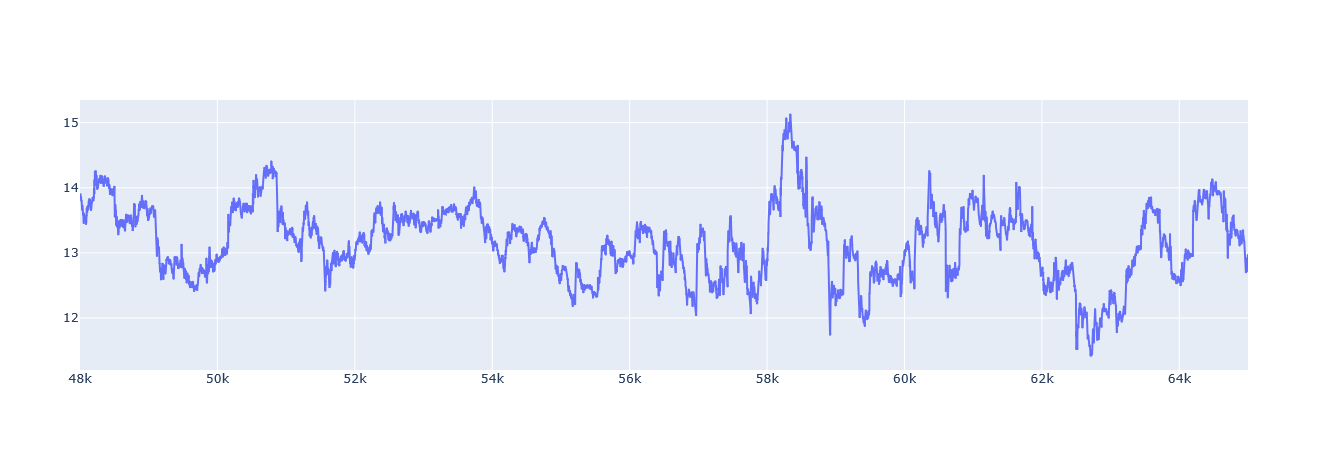

In [8]:
trace0 = go.Scatter(x=df.index, y=df.Close)
data = [trace0]
py.iplot(data)

Defining our matplotlib properties so we have consistent graphs over this notebook:

In [9]:
fig_size = plt.rcParams["figure.figsize"] #loads current figure size
print('old size:',fig_size) #prints the size
fig_size[0] = 15 #sets the X size to 15
fig_size[1] = 8 #sets the Y size to 8
plt.rcParams["figure.figsize"] = fig_size #sets this numbers to the new size
plt.rcParams["xtick.labelsize"] = 20
fig_size = plt.rcParams["figure.figsize"] #loads the figure size for checking
plt.rcParams.update({'font.size': 18})
print ('new size:',fig_size) #prints the figure size

old size: [6.0, 4.0]
new size: [15.0, 8.0]


Text(0.5, 0, 'Minute')

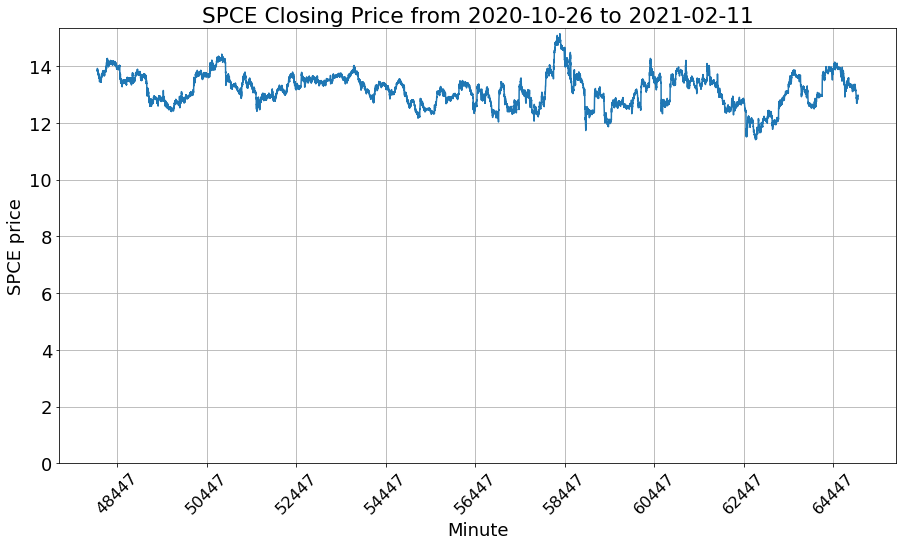

In [10]:
# x = [datetime.strptime(d,'%Y-%m-%d').date() for d in v.index.values] #convert date to something python understands
x = df.index
y = df.Close #plots which ever catagory you entered above

# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) #display the date properly
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2000)) #x axis tick every 60 days
# plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100)) # sets y axis tick spacing to 100

plt.plot(x,y) #plots the x and y
plt.grid(True) #turns on axis grid
plt.ylim(0) #sets the y axis min to zero
plt.xticks(rotation=45,fontsize = 16) #rotates the x axis ticks 90 degress and font size 10
plt.title('SPCE Closing Price from {} to {}'.format(df.Date.min(), df.Date.max())) #prints the title on the top
plt.ylabel('SPCE price') #labels y axis
plt.xlabel('Minute') #labels x axis

# plt.tick_params(
#     axis='both',          # changes apply to the x-axis
#     which='major',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False) # labels along the bottom edge are off


Adding the On Balance Volume indicator, which combines the closing price and the volume indicator according to a simple formula:
$$\text{OBV}=\text{OBV}_{\text{prev}}+\begin{cases}
\text{volume} & ,\text{if }\text{close}>\text{close}_{\text{prev}}\\
0 & ,\text{if }\text{close}=\text{close}_{\text{prev}}\\
-\text{volume} & ,\text{if }\text{close}<\text{close}_{\text{prev}}
\end{cases}$$

In [12]:
stock_df = stock_df.reset_index(drop=True)

In [13]:
new_df2 = on_balance_volume_creation(stock_df)
new_df2

,Close,On_Balance_Volume
0,13.840,13.298949
1,13.818,13.297271
2,13.870,13.302105
3,13.880,13.302272
4,13.910,13.303724
...,...,...
16995,12.940,8.085795
16996,12.950,8.116118
16997,12.970,8.145550
16998,12.980,8.243283


Using FINTA, adding:
- Exponential Moving Averages which is a running average that gives a bigger weight to the latest samples
- Boilinger Band which is a band that wraps around the price. When the price gets closer to the upper band, the price is likely to drop, and vice versa.

In [14]:
new_df2 = add_technical_indicators(new_df2, stock_df=stock_df)
new_df2

,Close,On_Balance_Volume,Exponential_moving_average,BB_UPPER,BB_MIDDLE,BB_LOWER
0,13.840,13.298949,13.840000,13.840000,13.840000,13.840000
1,13.818,13.297271,13.827778,13.858890,13.827778,13.796665
2,13.870,13.302105,13.845082,13.897287,13.845082,13.792877
3,13.880,13.302272,13.856911,13.913573,13.856911,13.800248
4,13.910,13.303724,13.872703,13.944112,13.872703,13.801295
...,...,...,...,...,...,...
16995,12.940,8.085795,12.887401,12.970108,12.829000,12.687892
16996,12.950,8.116118,12.899920,12.983242,12.833000,12.682758
16997,12.970,8.145550,12.913936,13.001417,12.843500,12.685583
16998,12.980,8.243283,12.927149,13.017675,12.855000,12.692325


Time to split our data into test, validation and training sets.

We also set the $y$ as the closing price of the next minute, and we'll use the MSE on it with our prediction for each minute.

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
train_percent = 0.7
val_percent = 0.2

X_train, y_train, X_val, y_val, X_test, y_test, y_reverse_normaliser = train_test_split(new_df2, train_percent, val_percent)

In [17]:
print('X_train.shape = ',X_train.shape)
print('X_val.shape = ',X_val.shape)
print('X_test.shape = ',X_test.shape)
print('y_train.shape = ',y_train.shape)
print('y_val.shape = ',y_val.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (11900, 6)
X_val.shape =  (3400, 6)
X_test.shape =  (1699, 6)
y_train.shape =  (11900, 1)
y_val.shape =  (3400, 1)
y_test.shape =  (1699, 1)


In [18]:
# convering to torch

X_train = torch.from_numpy(X_train).type(torch.Tensor)
X_val = torch.from_numpy(X_val).type(torch.Tensor).to(device)
X_test = torch.from_numpy(X_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_val = torch.from_numpy(y_val).type(torch.Tensor).to(device)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

We have our data ready.

Now for the model:

### LSTM

The following hyperparameters were found by optuna (the optimization is found under a notebook in this directory):

In [20]:
input_dim = 6
hidden_dim = 93
num_layers = 2
output_dim = 1
num_epochs = 123
dropout_p = 0.12042212494413294
lr = 0.0040181401574884285
bs = 415
bptt = 16
T = X_train.shape[0] // bs  # number of batches
leftover = X_train.shape[0] - T*bs

Inside the model we'll be feeding concurrent batches, and in each iteration each batch will pass a vector of length bptt=16:

<img src="../assets/data_dimensions.png" width=600 height=600 />

Now for the model:

In [21]:
model = LSTM_model(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers, dropout_p=dropout_p).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [22]:
train_loss, val_loss = train(model, criterion, optimizer, num_epochs, X_train, y_train, X_val, y_val, leftover, bptt, bs, T)

Epoch 0, Train MSE 0.171, Val MSE 0.021
Epoch 1, Train MSE 0.078, Val MSE 0.044
Epoch 2, Train MSE 0.026, Val MSE 0.028
Epoch 3, Train MSE 0.041, Val MSE 0.036
Epoch 4, Train MSE 0.047, Val MSE 0.031
Epoch 5, Train MSE 0.037, Val MSE 0.025
Epoch 6, Train MSE 0.026, Val MSE 0.025
Epoch 7, Train MSE 0.020, Val MSE 0.034
Epoch 8, Train MSE 0.024, Val MSE 0.039
Epoch 9, Train MSE 0.025, Val MSE 0.032
Epoch 10, Train MSE 0.019, Val MSE 0.024
Epoch 11, Train MSE 0.017, Val MSE 0.021
Epoch 12, Train MSE 0.017, Val MSE 0.019
Epoch 13, Train MSE 0.017, Val MSE 0.018
Epoch 14, Train MSE 0.015, Val MSE 0.016
Epoch 15, Train MSE 0.012, Val MSE 0.015
Epoch 16, Train MSE 0.011, Val MSE 0.015
Epoch 17, Train MSE 0.011, Val MSE 0.011
Epoch 18, Train MSE 0.007, Val MSE 0.007
Epoch 19, Train MSE 0.006, Val MSE 0.006
Epoch 20, Train MSE 0.006, Val MSE 0.004
Epoch 21, Train MSE 0.006, Val MSE 0.004
Epoch 22, Train MSE 0.005, Val MSE 0.004
Epoch 23, Train MSE 0.005, Val MSE 0.004
Epoch 24, Train MSE 0.004,

In [23]:
train_loss = np.array(train_loss)
val_loss = np.array(val_loss)

Text(0.5, 1.0, 'Training Loss')

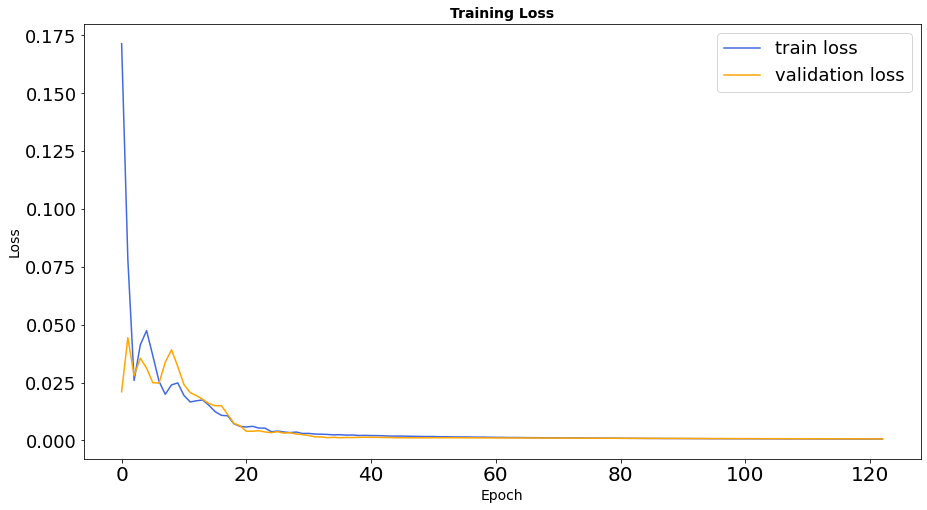

In [24]:
fig = plt.subplots()
ax = sns.lineplot(data=train_loss, color='royalblue', label='train loss')
ax2 = sns.lineplot(data=val_loss, color='orange', label='validation loss')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
# fig.set_figheight(6)
# fig.set_figwidth(16)

Text(0.5, 0, 'Epoch')

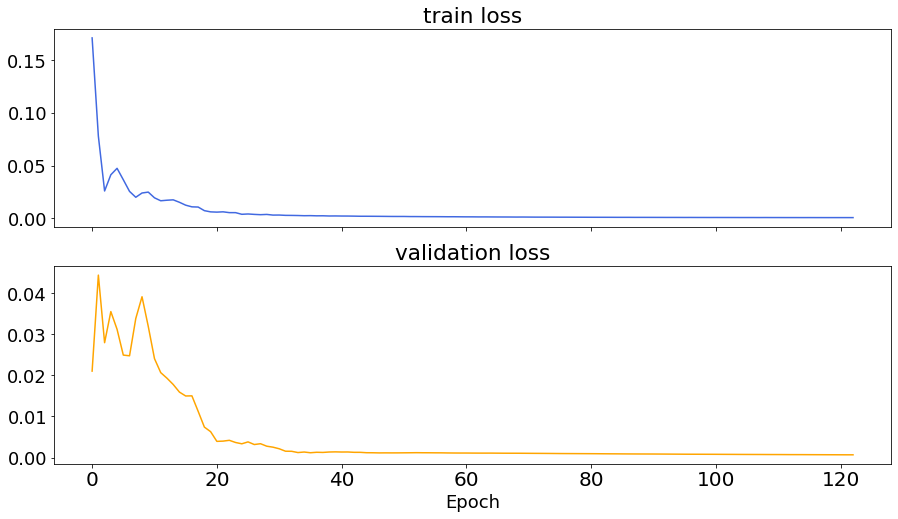

In [25]:
fig, axes = plt.subplots(2, 1, sharex=True)

# Bulbasaur
sns.lineplot(data=train_loss, color='royalblue', ax=axes[0])
axes[0].set_title('train loss')

# Charmander
ax2 = sns.lineplot(data=val_loss, color='orange', ax=axes[1])
axes[1].set_title('validation loss')

plt.xlabel('Epoch')

In [26]:
model = model.to(device)
model.eval()

LSTM_model(
  (lstm): LSTM(6, 93, num_layers=2, batch_first=True, dropout=0.12042212494413294)
  (fc): Linear(in_features=93, out_features=1, bias=True)
)

Feeding our whole train, validation and test splits to the model in order to plot them.

It's important to do it sequentially and propagate the hidden states between them.

In [27]:
y_train_pred_full = []
hidden = None

for k in range(0, len(X_train), bptt):
    x = X_train[k:k+bptt, :].unsqueeze(dim=0).to(device)
    y_train_pred, hidden = model(x, hidden)
    y_train_pred_full.extend(y_train_pred.squeeze().detach().cpu().numpy().tolist())

In [28]:
y_val_pred_full = []

for k in range(0, len(X_val), bptt):
    x = X_val[k:k+bptt, :].unsqueeze(dim=0).to(device)
    y_val_pred, hidden = model(x, hidden)
    y_val_pred_full.extend(y_val_pred.squeeze().detach().cpu().numpy().tolist())

In [29]:
y_test_pred_full = []

for k in range(0, len(X_test), bptt):
    x = X_test[k:k+bptt, :].unsqueeze(dim=0).to(device)
    y_test_pred, hidden = model(x, hidden)
    y_test_pred_full.extend(y_test_pred.squeeze().detach().cpu().numpy().tolist())

In [30]:
train_predict = np.array(y_train_pred_full).reshape(-1, 1)
train_predict = pd.DataFrame(y_reverse_normaliser.inverse_transform(train_predict))
train_original = pd.DataFrame(y_reverse_normaliser.inverse_transform(y_train.detach().cpu().numpy()))
print("train predict shape: ", train_predict.shape)
print("train original shape: ", train_original.shape)

train predict shape:  (11900, 1)
train original shape:  (11900, 1)


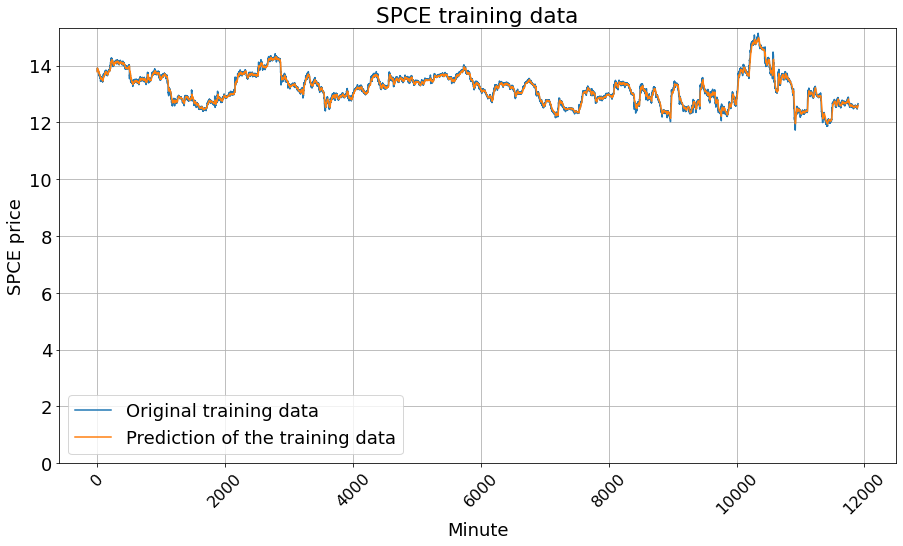

In [31]:
# x = [datetime.strptime(d,'%Y-%m-%d').date() for d in v.index.values] #convert date to something python understands
# x = v.index
# y = v.Close #plots which ever catagory you entered above

# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y')) #display the date properly
# plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60)) #x axis tick every 60 days
# plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100)) # sets y axis tick spacing to 100

plt.plot(train_original.index,train_original.values, label="Original training data") #plots the x and y
plt.plot(train_predict.index,train_predict.values, label="Prediction of the training data") #plots the x and y
plt.grid(True) #turns on axis grid
plt.ylim(0) #sets the y axis min to zero
plt.xticks(rotation=45,fontsize = 16) #rotates the x axis ticks 90 degress and font size 10
plt.title('SPCE training data') #prints the title on the top
plt.ylabel('SPCE price') #labels y axis
plt.xlabel('Minute') #labels x axis
plt.legend()

Computing validation prediction and plotting it:

In [32]:
val_predict = np.array(y_val_pred_full).reshape(-1, 1)
val_predict = pd.DataFrame(y_reverse_normaliser.inverse_transform(val_predict))
val_original = pd.DataFrame(y_reverse_normaliser.inverse_transform(y_val.detach().cpu().numpy()))
print("train predict shape: ", val_predict.shape)
print("train original shape: ", val_original.shape)

train predict shape:  (3400, 1)
train original shape:  (3400, 1)


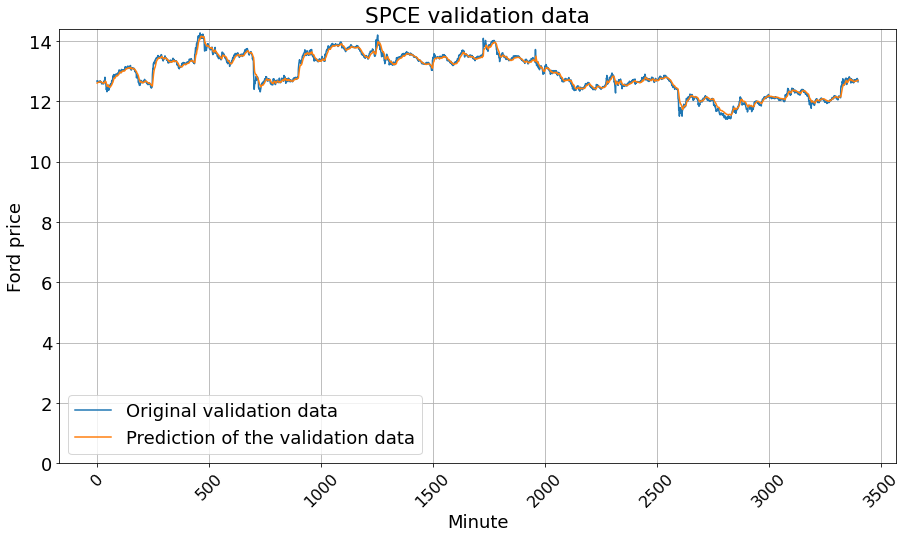

In [33]:
plt.plot(val_original.index, val_original.values, label="Original validation data") #plots the x and y
plt.plot(val_predict.index,val_predict.values, label="Prediction of the validation data") #plots the x and y
plt.grid(True) #turns on axis grid
plt.ylim(0) #sets the y axis min to zero
plt.xticks(rotation=45,fontsize = 16) #rotates the x axis ticks 90 degress and font size 10
plt.title('SPCE validation data') #prints the title on the top
plt.ylabel('Ford price') #labels y axis
plt.xlabel('Minute') #labels x axis
plt.legend()

Computing the test prediction and plotting it:

In [34]:
test_predict = np.array(y_test_pred_full).reshape(-1, 1)
test_predict = pd.DataFrame(y_reverse_normaliser.inverse_transform(test_predict))
test_original = pd.DataFrame(y_reverse_normaliser.inverse_transform(y_test.detach().cpu().numpy()))
print("train predict shape: ", val_predict.shape)
print("train original shape: ", val_original.shape)

train predict shape:  (3400, 1)
train original shape:  (3400, 1)


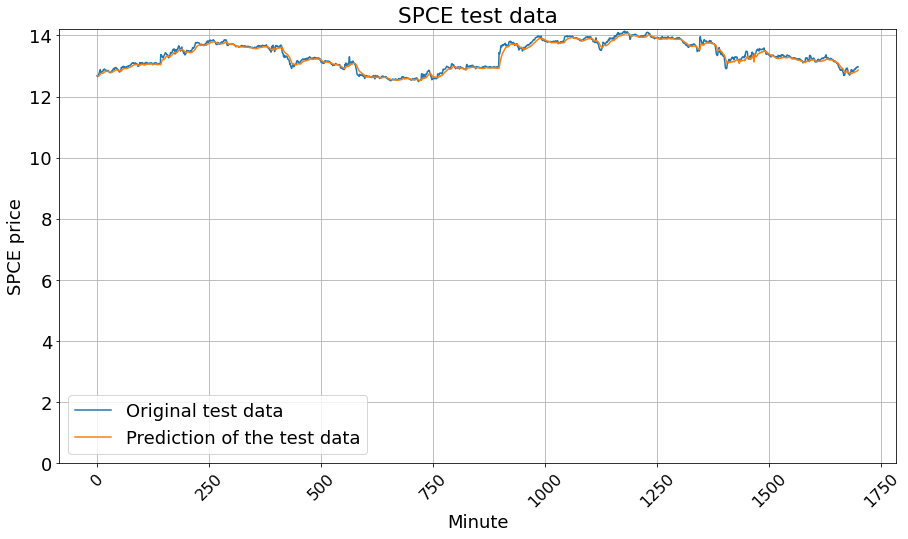

In [35]:
plt.plot(test_original.index, test_original.values, label="Original test data") #plots the x and y
plt.plot(test_predict.index,test_predict.values, label="Prediction of the test data") #plots the x and y
plt.grid(True) #turns on axis grid
plt.ylim(0) #sets the y axis min to zero
plt.xticks(rotation=45,fontsize = 16) #rotates the x axis ticks 90 degress and font size 10
plt.title('SPCE test data') #prints the title on the top
plt.ylabel('SPCE price') #labels y axis
plt.xlabel('Minute') #labels x axis
plt.legend()

We could also watch it zoomed in:

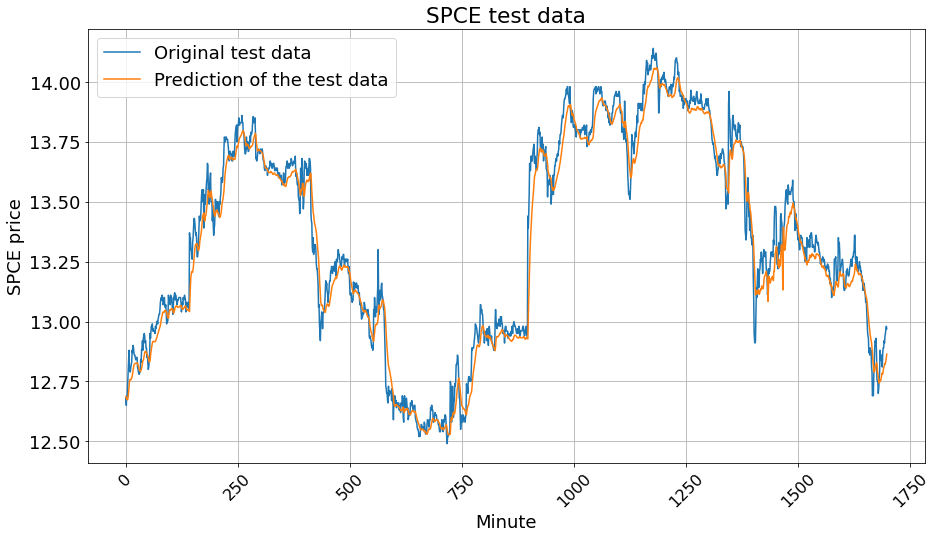

In [36]:
plt.plot(test_original.index, test_original.values, label="Original test data") #plots the x and y
plt.plot(test_predict.index,test_predict.values, label="Prediction of the test data") #plots the x and y
plt.grid(True) #turns on axis grid
plt.xticks(rotation=45,fontsize = 16) #rotates the x axis ticks 90 degress and font size 10
plt.title('SPCE test data') #prints the title on the top
plt.ylabel('SPCE price') #labels y axis
plt.xlabel('Minute') #labels x axis
plt.legend()

Adding dates back in order to save the results as pickles and prepare them for the bot:

In [119]:
test_original

,Date,Price
0,2021-02-01,12.680000
1,2021-02-01,12.650001
2,2021-02-01,12.690001
3,2021-02-01,12.690001
4,2021-02-01,12.740000
...,...,...
1694,2021-02-11,12.940000
1695,2021-02-11,12.950000
1696,2021-02-11,12.970000
1697,2021-02-11,12.980000


In [120]:
test_predict

,Date,Price
0,2021-02-01,12.693604
1,2021-02-01,12.687860
2,2021-02-01,12.679974
3,2021-02-01,12.680403
4,2021-02-01,12.682274
...,...,...
1694,2021-02-11,12.840854
1695,2021-02-11,12.849032
1696,2021-02-11,12.859448
1697,2021-02-11,12.873954


In [112]:
import pickle
with open('SPCE_original.pkl', 'wb') as file:

    pickle.dump(test_original, file)
    
with open('SPCE_predict.pkl', 'wb') as file:

    pickle.dump(test_predict, file)